# Data preprocessing - creating the dataframes

In [3]:
# imports 
from google.colab import drive
import json
import shutil
import os
import zipfile
import warnings
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import seaborn as sns 
import statistics
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import pandas as pd


In [4]:

json_objects = []

# Mounting Google Drive to access the zip file
drive.mount('/content/drive')

zip_path = '/content/drive/My Drive/Prometheus Data/OperatreFirst_PrometheusData_AppLearner.zip'
json_dir_path = '/content/OperatreFirst_PrometheusData_AppLearner'

# Extracting the zip files 
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Getting list of files in the zip
    file_names = zip_ref.namelist()
    # Extracting the files that start with 'container_cpu_' string
    for file_name in file_names:
      zip_ref.extract(file_name, json_dir_path)

# Looping through each extracted JSON file, reading and saving it as a JSON file in the Colab environment 
for file_name in os.listdir(json_dir_path):
    if file_name.startswith('container') and file_name.endswith('.json'):
        with open(os.path.join(json_dir_path, file_name), 'r') as f:
            json_data = [json.loads(line) for line in f]
        with open(f'{file_name[:-5]}_subset.txt', 'w') as f:
            f.write(json.dumps(json_data, indent=4))
# Delete the memory files - irrelevant
dir_path = '/content/OperatreFirst_PrometheusData_AppLearner/OperatreFirst_PrometheusData_AppLearner'
for file_name in os.listdir(dir_path):
    if not file_name.startswith('container_cpu_'):
        os.remove(os.path.join(dir_path, file_name))
    else: # Store the relevant json files as a dictionary
        if file_name.endswith('.json'):
          with open(os.path.join(dir_path, file_name), 'r') as f:
            json_data = json.load(f)
          json_objects.append(json_data)

Mounted at /content/drive


In [5]:
num_objects = len(json_objects)
print(f"There are {num_objects} json files.")

There are 5 json files.


In [ ]:
f_json = json_objects[0]
for k,v in f_json.items():
  print("key")
  print(k)
  print("Len values - each value is a dictionary - represents new data on the SAME application, with different time interval")
  print(len(v))
  print("-----------")
 

In [7]:
#Creating the df - each row represents a dataset (including all the values of the data)

#Only the first json - TODO LATER 
json_objects = json_objects[:1]
df = pd.DataFrame(columns=["application","namespace", "node","pod","start", "stop", "data"])
i=0
for data in json_objects: 
  for key, value in data.items():
      app_data = key.split(", ")
      application, namespace, node, pod = app_data[0],app_data[1],app_data[2], app_data[3]
      for v in value:
          time = v['start']
          start = datetime.strptime(v["start"], "%Y-%m-%d %H:%M:%S")
          stop = datetime.strptime(v["stop"], "%Y-%m-%d %H:%M:%S")
          data = v["data"]
          df.loc[i] = [application,namespace,node,pod, start, stop,data]
          i += 1

In [8]:
def aggregate_time(df, n, ma):
    """
    ma - the k for the rolling average window
    """
    start = df['start']
    data_list = df['data']
  
    med_data = []
    agg_time = []
    min_data = []
    max_data = []
    mean_data = []
    roll_avg = []
    for i in range(0, len(data_list), n):
      agg_time.append(start + timedelta(minutes = i))
      temp =data_list[i: i+n] 
      temp_med = np.median(temp)
      temp_mean = np.mean(temp)
      temp_min = min(temp)
      temp_max = max(temp)
      med_data.append(temp_med)
      min_data.append(temp_min)
      max_data.append(temp_max)
      mean_data.append(temp_mean)
      if i> ma:
        roll_data = data_list[i-ma:i]
        roll_avg.append(np.mean(roll_data))
      else:
        roll_avg.append(temp_mean)
  
    # Create dataframe
    app = [df['application'] for j in med_data]
    namespace = [df['namespace'] for j in med_data]
    node = [df['node'] for j in med_data]
    pod = [df['pod'] for j in med_data]
    app_df = pd.DataFrame({'application': app,
                            'namespace': namespace,
                            'node':node,
                            'pod':pod,
                          'time': agg_time,
                          'median': med_data,
                            'min': min_data,
                            'max': max_data,
                           'mean': mean_data,
                           'rolling_average':roll_avg})
    return app_df


In [ ]:
dfs_30 = []

for index, row in df.iterrows():
  print("Start:", row['start'])
  print("End:", row['stop'])
  print("The number of minutes information for CPU consumption in the dataframe is: ", len(row['data']))
  print("------------")
  app_df = aggregate_time(row, 30, ma=120)
  dfs_30.append(app_df)

In [10]:
print("The amount of dataframes is: ", str(len(dfs_30)))
# count the number of dataframes in the list where 'median' column is 0 in all rows
count = 0
for df in dfs_30:
    if (df['median'] == 0).all():
        count += 1

print(f"There are {count} dataframes in the list where 'median' column is 0 in all rows.")

print("\nAn example for a dataframe:")
dfs_30[50].head(2)# create a list of sample dataframes

The amount of dataframes is:  18892
There are 1225 dataframes in the list where 'median' column is 0 in all rows.

An example for a dataframe:


,application,namespace,node,pod,time,median,min,max,mean,rolling_average
0,kube-rbac-proxy,openshift-monitoring,oct-03-03-compute,alertmanager-main-0,2022-06-10 12:00:00,0.000172,0.000150,0.000240,0.000180,0.000180
1,kube-rbac-proxy,openshift-monitoring,oct-03-03-compute,alertmanager-main-0,2022-06-10 12:30:00,0.000166,0.000134,0.000259,0.000175,0.000175


# Explenatory Data Analysis  


In [11]:
df_concat = pd.concat(dfs_30)


Let's look at an example for one dataset statistics

In [13]:

# check for null values
print('Null values:\n', dfs_30[40].isnull().sum())

# compute basic statistics
print('\nStatistics:\n', dfs_30[40].describe())


Null values:
 application        0
namespace          0
node               0
pod                0
time               0
median             0
min                0
max                0
mean               0
rolling_average    0
dtype: int64

Statistics:
          median       min       max      mean  rolling_average
count  5.000000  5.000000  5.000000  5.000000         5.000000
mean   0.000117  0.000048  0.000168  0.000114         0.000114
std    0.000022  0.000045  0.000004  0.000020         0.000020
min    0.000081  0.000000  0.000164  0.000084         0.000084
25%    0.000115  0.000000  0.000166  0.000111         0.000111
50%    0.000119  0.000068  0.000167  0.000113         0.000113
75%    0.000133  0.000081  0.000170  0.000129         0.000129
max    0.000136  0.000091  0.000175  0.000135         0.000135


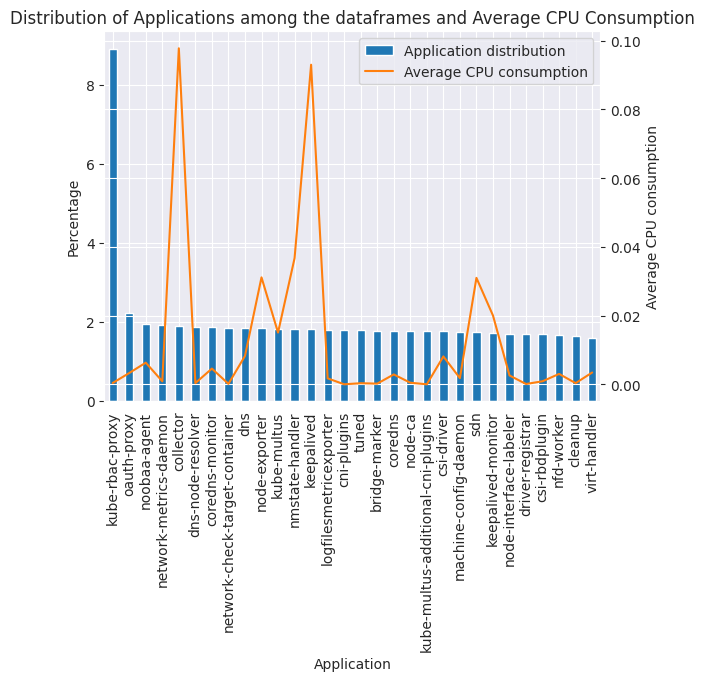

In [ ]:
# Count the number of occurrences of each application
app_counts = df_concat['application'].value_counts(normalize=True).sort_values(ascending=False)[:30]*100

fig, ax = plt.subplots()
app_counts.plot.bar(ax=ax, color='C0', label='Application distribution')
ax.set_title('Distribution of Applications among the dataframes and Average CPU Consumption')
ax.set_xlabel('Application')
ax.set_ylabel('Percentage')

cpu_averages = df_concat.groupby('application')['mean'].mean()
ax2 = ax.twinx()
cpu_averages[app_counts.index].plot(ax=ax2, color='C1', label='Average CPU consumption')
ax2.set_ylabel('Average CPU consumption')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()


The bar plot shows the distribution of the top 35 most common applications across all dataframes in terms of the percentage of dataframes in which they appear (without reffering to the duration of time recorded for each df).

The seccond y-axis shows the average CPU cosumption for each application. Here we can see that the aggregation is at the application level so it might hide variations in resource usage at the pode/node level but still provide a useful high-level overiew of the usage trends for each app.

We can see that the application 'kube-rbac-proxy' stands out with more than 8% of the total dataframes, which is a significant difference compared to the other applications that are distributed more uniformly.

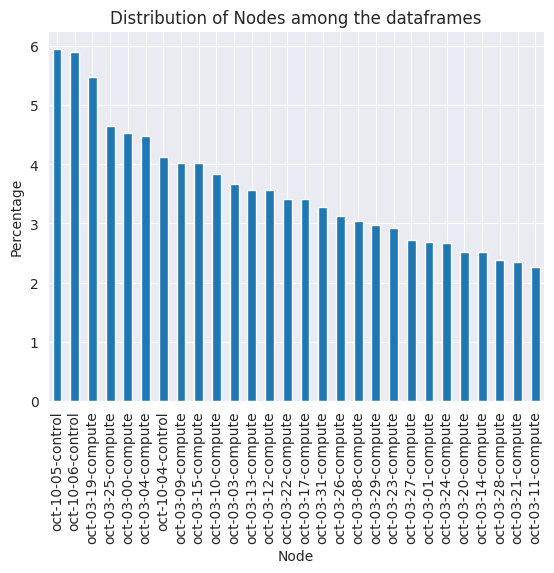

In [ ]:
# Count the number of occurrences of each node
node_counts = df_concat['node'].value_counts(normalize=True).sort_values(ascending=False)[:30]*100

fig, ax = plt.subplots()
node_counts.plot.bar(ax=ax, color='C0')
ax.set_title('Distribution of Nodes among the dataframes')
ax.set_xlabel('Node')
ax.set_ylabel('Percentage')

plt.show()


The bar plot shows the distribution of the top 30 most common nodes across all dataframes in terms of the percentage of dataframes in which they appear (without reffering to the duration of time recorded for each df).
 

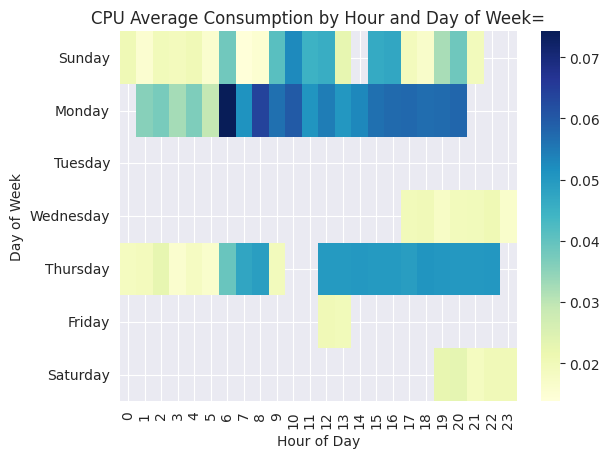

In [ ]:
warnings.filterwarnings('ignore')

# Create new columns 
ordered_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_concat['day_of_week'] = df_concat['time'].dt.strftime('%A')
df_concat['day_of_week'] = pd.Categorical(df_concat['day_of_week'], ordered_days)
df_concat['hour_of_day'] = df_concat['time'].dt.hour

# Group by day of the week and hour of the day and calculate the median CPU consumption
grouped = df_concat.groupby(['day_of_week', 'hour_of_day'])['mean'].mean().reset_index()
heatmap_data = grouped.pivot('day_of_week', 'hour_of_day', 'mean').reindex(ordered_days)
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('CPU Average Consumption by Hour and Day of Week=')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


The plot shows the median CPU consumption by day of the week and hour of the day to identify patterns and trends in CPU consumption for the over the course of a week.


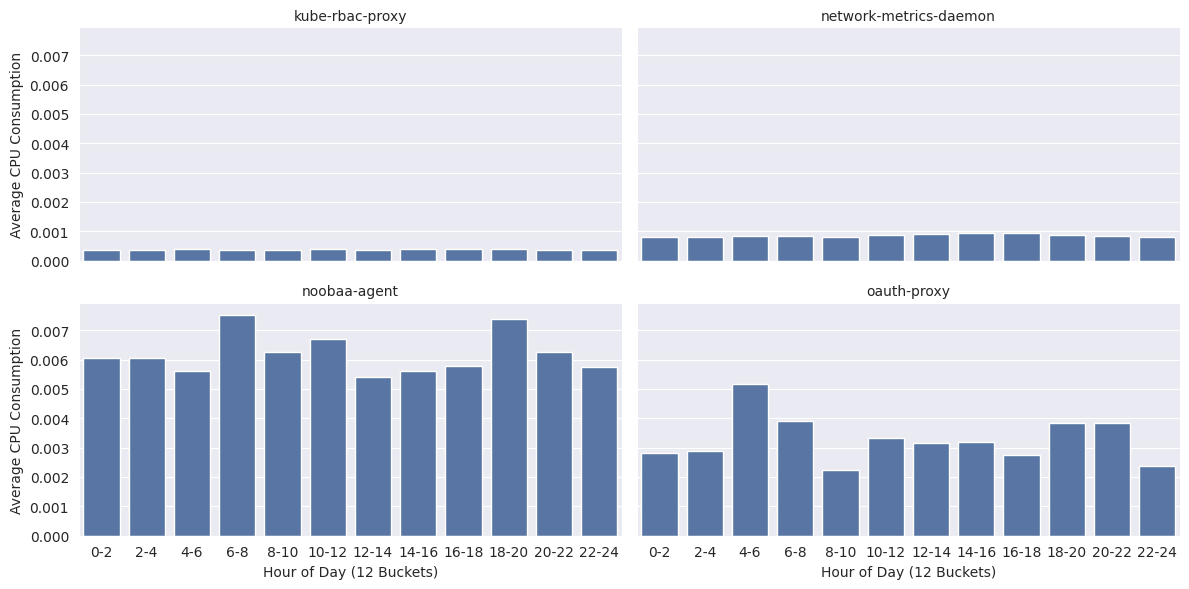

In [ ]:
# Filter for top 4 applications
first_4_apps = app_counts.index[:4]
merged_df_top_apps = df_concat[df_concat['application'].isin(first_4_apps)]

# Create hour bins
merged_df_top_apps['hour'] = merged_df_top_apps['time'].dt.hour
merged_df_top_apps['hour_bin'] = pd.cut(merged_df_top_apps['hour'], bins=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24], labels=['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20', '20-22', '22-24'])

# Calculate hourly averages
hourly_avg_top_apps = merged_df_top_apps.groupby(['application', 'hour_bin'])['mean'].mean().reset_index()

# Create facet grid
g = sns.FacetGrid(data=hourly_avg_top_apps, col='application', col_wrap=2, height=3, aspect=2)
g.map_dataframe(sns.barplot, x='hour_bin', y='mean', color='b')
g.set_axis_labels('Hour of Day (12 Buckets)', 'Average CPU Consumption')
g.set_titles(col_template='{col_name}')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()
plt.rcdefaults()



The plot shows the average CPU consumption of the top 4 applications over 12 buckets of hours in a day.

We can see that each of the top 4 applications has a different scale of CPU consumption and that the CPU consumption is relatively uniformly distributed across the different hours of the day for each application, although some applications have slightly higher consumption during certain hours compared to others.

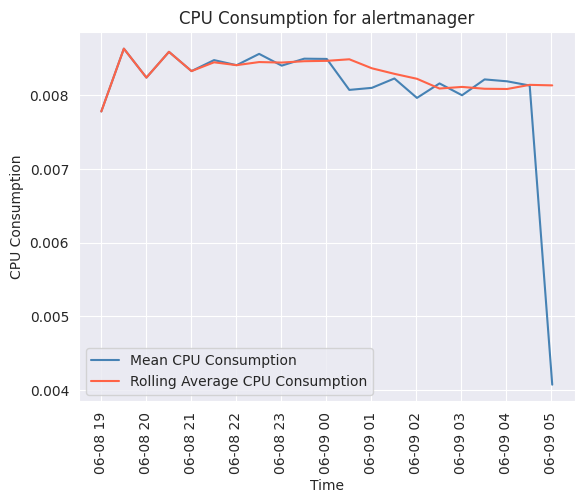

In [ ]:
sns.set_style("darkgrid")  # set the seaborn style
sns.lineplot(data=dfs_30[12], x='time', y='mean', color='steelblue', label='Mean CPU Consumption')
sns.lineplot(data=dfs_30[12], x='time', y='rolling_average', color='tomato', label='Rolling Average CPU Consumption')
plt.title(f'CPU Consumption for {dfs_30[12]["application"].iloc[0]}')
plt.xlabel('Time')
plt.ylabel('CPU Consumption')
plt.xticks(rotation=90)

=plt.legend(loc='lower left')

plt.show()


This plot shows the CPU consumption over time for a specific application named 'alertmanager'. We can see that the trend is relatively stable with a slight decrease, followed up by a sudden change of a drop with the application using only half of its previous CPU consumption within one minute